# **Trends on Crime using CTA Ridership Data Analysis**

**Team Member:** Srijita Banerjee (sbane4@uic.edu)

**Description:** This notebook looks at crime data from public data repository of *Chicago Transit Authority* *(CTA)* and attempts to figure out a certain trend of crime rates and CTA public transportation.

In [11]:
# installing matplotlib
!pip install matplotlib

# installing seaborn
!pip install seaborn

In [12]:
# importing necessary libraries
import pandas as pd # for data loading and manipulation
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for enhanced plotting
import numpy as np # for numerical operations

from datetime import datetime # for handling and formatting dates

import warnings
warnings.filterwarnings('ignore') # to avoid warning messages while plotting or merging

In [13]:
# list of crime data files
crime_files = ['CTA_Crime_2011.csv',
               'CTA_Crime_2020.csv',
               'CTA_Crimes_2010.csv',
               'CTA_Crimes_2020.csv',
               'CTA_Crimes_2021.csv',
               'CTA_Crimes_2022.csv',
               'CTA_Crimes_2023.csv',
               'CTA_Crimes_2024.csv']

# loading and combining files
crime_df = pd.concat([pd.read_csv(file) for file in crime_files], ignore_index = True)

# parsing 'Date' column from String --> DateTime object
crime_df['Date'] = pd.to_datetime(crime_df['Date'])
#print(crime_df['Date'].dtype) #TESTING

In [15]:
# group crimes by day
crime_daily = crime_df.groupby(crime_df['Date'].dt.date).size().reset_index(name='crime_count')

#print(crime_daily.shape) #TESTING

## CTA Crime Data Statistics Analysis
This is everything inferred from doing the following calculations.


---


1. **Mean is: 12.47 and Standard Deviation is: 5.53**


*   About **12 crimes** happen any day on the CTA.
*   Most days are **within 5-6 crimes** up or down from that average.

*   So, big crime spikes should be days with **way more than normal**.


---



2. **Spike threshold is: 23.54** The *spike threshold* tells us that if any day had more than ~24 crimes, it's a high crime spike day.


---



3. We found a total of **104 days (out of 2585 days of the data collected)** where crime was unusually high (greater than ~23.54 crimes per day).


---



In [16]:
# calculating Daily Average Crime and Standard Deviation of Daily Crime
mean_crime = crime_daily['crime_count'].mean()
std_crime = crime_daily['crime_count'].std()

print(f"Average daily crime: {mean_crime:.2f}")
print(f"Standard deviation of daily crime: {std_crime:.2f}")

Average daily crime: 12.47
Standard deviation of daily crime: 5.53


In [17]:
# calculating spike threshold
threshold = mean_crime + 2 * std_crime
print(f"Crime spike threshold: {threshold:.2f}")

Crime spike threshold: 23.54


In [18]:
# filtering days with crime_count above threshold
spike_days = crime_daily[crime_daily['crime_count'] > threshold]
print(spike_days)

            Date  crime_count
6     2010-01-07           24
10    2010-01-11           26
13    2010-01-14           26
14    2010-01-15           31
18    2010-01-19           26
...          ...          ...
2336  2024-05-25           25
2342  2024-05-31           24
2349  2024-06-07           30
2441  2024-09-07           24
2451  2024-09-17           24

[104 rows x 2 columns]


## Relationship between Crime and Ridership
This section deals with inferring the relationship of Daily CTA Crime Data with Daily CTA Ridership Data with respect to **date of the crime occuring.**

---

We start with merging the data of crime rates with ridership data found in CTA public data repository.

In [20]:
# loading ridership data
ridership_df = pd.read_csv('CTA_Ridership_Daily_Boarding_Totals.csv')

# date column in ridership data parsed
ridership_df['service_date'] = pd.to_datetime(ridership_df['service_date'])

# keep only ridership records after 2010 (for now!)
ridership_df = ridership_df[ridership_df['service_date'] >= '2010-01-01']

ridership_df['service_date_only'] = ridership_df['service_date'].dt.date

# merge
merged_df = pd.merge(
    ridership_df,
    crime_daily,
    left_on='service_date_only',
    right_on = 'Date',
    how = 'left'
)

# fill missing crime counts
merged_df['crime_count'] = merged_df['crime_count'].fillna(0)

# dropping the extra 'Date' column
merged_df = merged_df.drop(columns = ['Date','service_date_only'])

print(merged_df.head())
print(merged_df.shape)

  service_date day_type     bus  rail_boardings  total_rides  crime_count
0   2010-01-01        U  348324          217060       565384         15.0
1   2010-01-02        A  484655          264011       748666         12.0
2   2010-01-03        U  354762          200944       555706          7.0
3   2010-01-04        W  938766          569397      1508163         12.0
4   2010-01-05        W  970860          589044      1559904         14.0
(5541, 6)


## Plotting **Crime Rate** & Ridership over **Time**
I have plotted the relationship of crime rates with CTA public transportation usage (overall) over the course of almost 15 years (2010 - 2024) The plot drawn shows increased crime rates across various timelines, such as years between **2010-2012 (pre-pandemic)**, and considerably somewhat lesser crime between the years **2020 and 2024 (post-pandemic)**.

     service_date  crime_count  total_rides
25     2010-01-26         38.0      1690887
635    2011-09-28         32.0      1812277
14     2010-01-15         31.0      1677327
102    2010-04-13         31.0      1711125
165    2010-06-15         31.0      1635029
270    2010-09-28         31.0      1781942
48     2010-02-18         31.0      1700119
20     2010-01-21         31.0      1696830
5333   2024-06-07         30.0       923009
3597   2020-01-06         30.0      1409870


<function matplotlib.pyplot.show(close=None, block=None)>

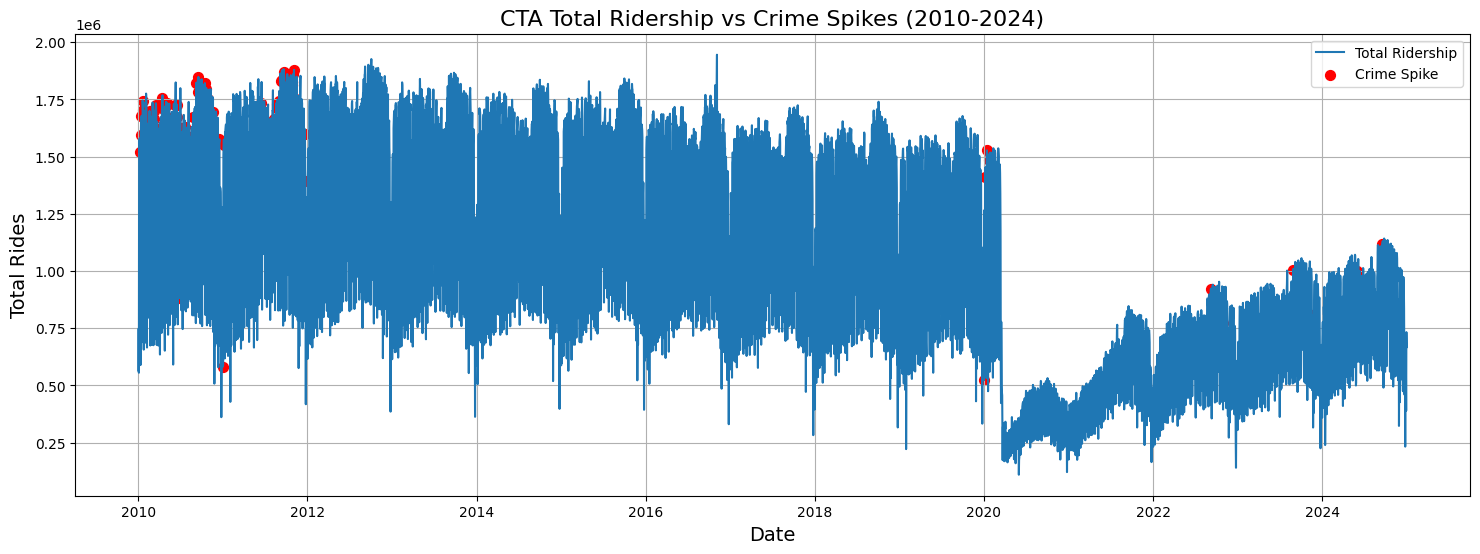

In [21]:
# setting crime spike threshold from before
crime_spike_threshold = threshold

# creating a boolean column for crime spikes
merged_df['is_crime_spike'] = merged_df['crime_count'] > crime_spike_threshold

# sort merged data by crime_count in descending order
spike_candidates = merged_df.sort_values('crime_count', ascending = False)

# view the top 10 spike days
print(spike_candidates[['service_date', 'crime_count', 'total_rides']].head(10))

# plotting now
plt.figure(figsize = (18,6))

# plotting total ridership
sns.lineplot(data = merged_df, x = 'service_date', y = 'total_rides', label = 'Total Ridership')

# crime spike days overlayed
spike_days = merged_df[merged_df['is_crime_spike']]
plt.scatter(spike_days['service_date'], spike_days['total_rides'], color = 'red', s = 50, label = 'Crime Spike')

# final add-ons to the plot
plt.title('CTA Total Ridership vs Crime Spikes (2010-2024)', fontsize = 16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Rides', fontsize=14)
plt.legend()
plt.grid(True)
plt.show